In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score,train_test_split
from pandas.tools.plotting import scatter_matrix

In [4]:
def process_data(df):
    df['Female'] = pd.factorize(df['Sex'])[0]
    df.loc[df['Age'].isnull(), 'Age'] = df['Age'].mean()
    df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare'].median()
    df.loc[df['Cabin'].isnull(), 'Cabin'] = 'U0'
    df.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].dropna().mode()[0]
    
    #A.S. Dummy columns are supposed to be better, since some regression algorithms will think that
    #the numbers have value (2>1>0). 
    df["Embarked"].fillna(0, inplace=True)
    df.loc[df["Embarked"] == "S", "Embarked"] = 0
    df.loc[df["Embarked"] == "C", "Embarked"] = 1
    df.loc[df["Embarked"] == "Q", "Embarked"] = 2
    #dummies_df = pd.get_dummies(df['Embarked'])
    #def addEmbarked(name):
    #    return 'Embarked_' + name
    #dummies_df = dummies_df.rename(columns=addEmbarked)
    #df = pd.concat([df, dummies_df], axis=1)
    #df['EmbarkedNum'] = pd.factorize(df['Embarked'])[0]
    
    import re
    def getDeck(cabin):
        match = re.search("([A-Z])", cabin)
        return match.group(1) if match is not None else None
    def getCabinNum(cabin):
        match = re.search("([0-9]+)", cabin)
        return match.group(1) if match is not None else None
    
    df['Deck'] = df['Cabin'].map(getDeck)
    df['DeckNum'] = df["Deck"]
    #df['DeckNum'] = pd.factorize(df['Deck'])[0]     #These don't put the Decks in order
    def getCabinVal(df):
        df.loc[df["Deck"] == "A", "DeckNum"] = 0
        df.loc[df["Deck"] == "B", "DeckNum"] = 1
        df.loc[df["Deck"] == "C", "DeckNum"] = 2
        df.loc[df["Deck"] == "D", "DeckNum"] = 3
        df.loc[df["Deck"] == "E", "DeckNum"] = 4
        df.loc[df["Deck"] == "F", "DeckNum"] = 5
        df.loc[df["Deck"] == "G", "DeckNum"] = 6
        df.loc[df["Deck"] == "T", "DeckNum"] = 7
        df.loc[df["Deck"] == "U", "DeckNum"] = np.random.randint(0,7)
    getCabinVal(df)
    #df['CabinNum'] = df['Cabin'].map(getCabinNum)
    #df.loc[df['CabinNum'].isnull(), 'CabinNum'] = 0
    
    df["SexNum"] = pd.factorize(df["Sex"])[0]
    MaxChildAge = 13
    df["WomenChildren"] = df["SexNum"]
    df.loc[df["Age"] < MaxChildAge, "WomenChildren"] = 1
    
    def numNames(name):
        return len(re.split(' ', name))
    df['NumNames'] = df['Name'].map(numNames)
    
    def getTitle(name):
        match = re.search(", (.*?)\.", name)
        return match.group(1) if match is not None else None
    df['Title'] = df['Name'].map(getTitle)
    
    df.loc[df['Title'] == 'Jonkheer', 'Title'] = 'Master'
    df.loc[df['Title'].isin(['Ms', 'Mlle']), 'Title'] = 'Miss'
    df.loc[df['Title'] == 'Mme', 'Title'] = 'Mrs'
    df.loc[df['Title'].isin(['Capt', 'Don', 'Major', 'Col', 'Sir']), 'Title'] = 'Sir'
    df.loc[df['Title'].isin(['Dona', 'Lady', 'the Countess']), 'Title'] = 'Lady'
    df = pd.concat([df, pd.get_dummies(df['Title']).rename(columns=lambda x: 'Title_' + str(x))], axis=1)
    
    return df

In [5]:
df = pd.read_csv('data/train.csv')
df = process_data(df)

In [45]:
df.columns
#survival        Survival (0 = No; 1 = Yes)
#pclass          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
#name            Name
#sex             Sex
#age             Age
#sibsp           Number of Siblings/Spouses Aboard
#parch           Number of Parents/Children Aboard
#ticket          Ticket Number
#fare            Passenger Fare
#cabin           Cabin
#embarked        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Female', u'Deck', u'DeckNum', u'SexNum', u'WomenChildren',
       u'NumNames', u'Title', u'Title_Dr', u'Title_Lady', u'Title_Master',
       u'Title_Miss', u'Title_Mr', u'Title_Mrs', u'Title_Rev', u'Title_Sir'],
      dtype='object')

In [6]:
df["Deck"].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [7]:
#np.where(df["Deck"] == "F")
df[["DeckNum","Deck"]].head()

,DeckNum,Deck
0,0,U
1,2,C
2,0,U
3,2,C
4,0,U


### Random Forest explanation - 

Each decision tree in the forest is deterministic and is constructed from a random subset of the data. E.g: For a given tree, every time it is cloudy, hot and windy, I will not play tennis. But there could be a similar data point where I do play tennis in a different tree. However it is not obvious how a decision tree handles two data points with the same features (clouds/no clouds, hot/cold, windy/not windy) but different outcomes (play/not play tennis), since a tree is fundamentally deterministic.

Each tree in the forest is different since they are constructed from different subsets of features and data. Once the forest is built, a new data point is run through the forest and all the trees democratically vote to decide the outcome (could be weighted by some metric).  

In [8]:
#Random Forest
features = ["SexNum","WomenChildren","DeckNum","Fare"]
response = df.Survived
train = df[features]

(0.80925388475724036, 0.032070136027965337)


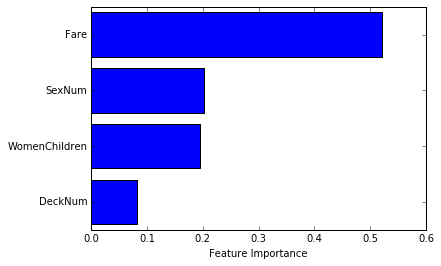

In [40]:
#Try Random Forest
#alg = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_split=5,random_state=1)
alg = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=1, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                              max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                              verbose=0, warm_start=False, class_weight=None)
scores=cross_validation.cross_val_score(alg,train,response,cv=6)
print(scores.mean(), scores.std())
alg.fit(train,response)
importances = alg.feature_importances_

indecies = np.argsort(importances)

plt.barh(range(len(importances)),importances[indecies], align='center')
plt.yticks(range(len(importances)),train.columns[indecies])
plt.xlabel('Feature Importance')
plt.show()

In [36]:
#Try other forms of fitting that require scaling 
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(train)

In [23]:
#Try Logistic Regression
from sklearn.linear_model import LogisticRegression
alg = LogisticRegression(random_state=1)
scores = cross_val_score(alg, X, response, cv=10)
print(scores.mean(), scores.std())

(0.77778430371126994, 0.028239861697599587)


### Support Vector Machine (SVM) Explanation

SVM operates by

In [29]:
#Try Support Vector Machine (SVM) - get best fit parameters
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

C_range = np.logspace(-3, 3, 5)       #A.S. Logspace is important
gamma_range = np.logspace(-3, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(response, n_iter=5, test_size=0.3, random_state=42)  #creates a cross validation set, n_iter = n_chunks
grid = GridSearchCV(SVC(kernel='rbf'), scoring="accuracy", param_grid=param_grid, cv=cv)
grid.fit(X, response) 
print "The best parameters are %s with a score of %0.4f" % (grid.best_params_, grid.best_score_)

The best parameters are {'C': 1.0, 'gamma': 0.001} with a score of 0.7813


In [30]:
#Fit best fit parameters for SVM
model=SVC(C=1.0, gamma=0.001)
scores=cross_val_score(model,X,response,cv=10)
print(scores.mean(), scores.std())

(0.79342753376461228, 0.033389091231599506)


### K-Nearest Neighbor Algorithm

(0.79435757353788994, 0.033585940473055229)


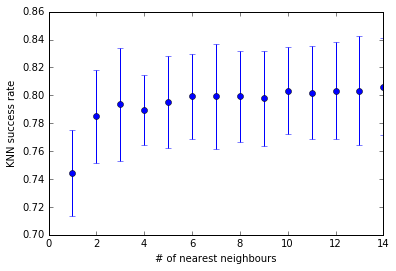

In [54]:
#Try a K-nearest neighbour algorithm, find optimum nearest neighbor (nn) value
from sklearn.neighbors import KNeighborsClassifier
nn = np.arange(1,15)                          #Number of nearest neighbours for the KNN alg.
scores_mean = []
scores_std = []

#need to make a train subset and a test subset from the training data
X_train,X_test,y_train,y_test=train_test_split(X,response,test_size=0.2,random_state=42)

for n in nn:
    knn = KNeighborsClassifier(n_neighbors=n, weights="distance")
    scores=cross_val_score(knn,X_train,y_train,cv=6,scoring='accuracy')
    scores_mean.append(np.mean(scores))
    scores_std.append(np.std(scores))

plt.plot(nn,scores_mean,'o', label='data')
plt.ylabel("KNN success rate")
plt.xlabel("# of nearest neighbours")
plt.errorbar(nn,scores_mean, yerr=scores_std, linestyle='None', color='b',label='')
print(np.mean(scores_mean), np.mean(scores_std))